#IMPORT DEL DATASET

In [0]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from scipy.stats.stats import pearsonr
import pandas_profiling

# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Replace Missing Values
- ACCESSING DATA QUALITY MISSING VALUES

In [62]:
df = pd.read_csv('/content/drive/My Drive/PROGETTO DATA MINING 1/credit.csv') 
df.head()

Loan ID  ... Tax Liens
0  14dd8831-6af5-400b-83ec-68e61888a048  ...       0.0
1  4771cc26-131a-45db-b5aa-537ea4ba5342  ...       0.0
2  4eed4e6a-aa2f-4c91-8651-ce984ee8fb26  ...       0.0
3  77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a  ...       0.0
4  d4062e70-befa-4995-8643-a0de73938182  ...       0.0

[5 rows x 19 columns]

In [63]:
print("Record attuali: ")
df.index.size

Record attuali: 


100514

rimuovo le righe totalmente nulle 

In [64]:
df.drop(df.tail(514).index, inplace=True) # drop last 514 rows
missing_values_table(df)

Your selected dataframe has 19 columns.
There are 7 columns that have missing values.


Missing Values  % of Total Values
Months since last delinquent           53141               53.1
Credit Score                           19154               19.2
Annual Income                          19154               19.2
Years in current job                    4222                4.2
Bankruptcies                             204                0.2
Tax Liens                                 10                0.0
Maximum Open Credit                        2                0.0

In [65]:
print("Record attuali: ")
df.index.size

Record attuali: 


100000

rimuovo le righe duplicate 

In [0]:
df.drop_duplicates(keep=False,inplace=True) 

In [67]:
print("Record attuali: ")
df.index.size

Record attuali: 


79570

aggiusto i valori di purpose

In [68]:
df['Purpose'] = df['Purpose'].str.replace('other', 'Other')
df['Purpose'].value_counts()

Debt Consolidation      63116
Other                    6947
Home Improvements        4635
Business Loan            1163
Buy a Car                1065
Medical Bills             839
Buy House                 486
Take a Trip               403
major_purchase            308
small_business            227
moving                    120
wedding                    95
Educational Expenses       83
vacation                   77
renewable_energy            6
Name: Purpose, dtype: int64

aggiusto i valori di home ownership

In [69]:
df['Home Ownership'].value_counts()
df['Home Ownership'].replace(to_replace = 'HaveMortgage', value = 'Home Mortgage', inplace=True)
df['Home Ownership'].value_counts()

Home Mortgage    38838
Rent             33516
Own Home          7216
Name: Home Ownership, dtype: int64

rimuovo la colonna months since last delinquent, in quanto ha un ammontare di valori nulli superiore al 50%

In [70]:
df.drop(columns = 'Months since last delinquent', axis=1, inplace=True)
missing_values_table(df)

Your selected dataframe has 18 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values
Credit Score                   19154               24.1
Annual Income                  19154               24.1
Years in current job            3382                4.3
Bankruptcies                     176                0.2
Tax Liens                          8                0.0
Maximum Open Credit                2                0.0

In [71]:
print("Record attuali: ")
df.index.size

Record attuali: 


79570

aggiusto credit score

In [0]:
df['Credit Score'] = np.where(df['Credit Score']>900, df['Credit Score']/10, df['Credit Score'])

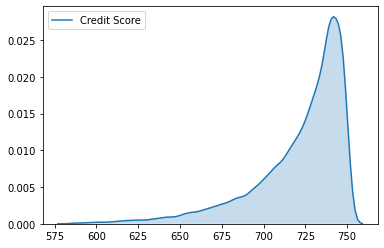

In [73]:
x = df['Credit Score']
sns.kdeplot(x, shade=True);

rimuovo infine le prime due colonne, loan e customer id, in quanto utili a fini di identificazione. (rimozione avvenuta solo ora per previa eliminazione di record duplicati) 

In [0]:
df.drop(labels=['Loan ID', 'Customer ID'], axis=1, inplace=True)

In [75]:
df.head()

Loan Status  Current Loan Amount  ... Bankruptcies  Tax Liens
1   Fully Paid             262328.0  ...          0.0        0.0
2   Fully Paid           99999999.0  ...          0.0        0.0
4   Fully Paid             176220.0  ...          0.0        0.0
5  Charged Off             206602.0  ...          0.0        0.0
6   Fully Paid             217646.0  ...          1.0        0.0

[5 rows x 16 columns]

In [76]:
missing_values_table(df)

Your selected dataframe has 16 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values
Credit Score                   19154               24.1
Annual Income                  19154               24.1
Years in current job            3382                4.3
Bankruptcies                     176                0.2
Tax Liens                          8                0.0
Maximum Open Credit                2                0.0

ho valori nulli in:

- Credit Score
- Annual Income
- Years in current Job
- Bankruptcies
- Tax Liens
- Maximum Open Credit

sfrutto le regole di associazione più frequenti per capire come sostituirli.

sostituzione:

- Credit Score: GOOD in range (670-739)
- Annual Income: NORMAL in range (0, 2000000)
- Years in current Job: UP TO TEN in range (1-10) 
- Bankruptcies: NONE = 0 
- Tax Liens: NONE = 0 
- Maximum Open Credit: NORMAL in range (100000,500000)


In [0]:
#SOSTITUISCO I VALORI MANCANTI CON UN NUMERO CASUALE NEL RANGE INDICATO

In [0]:
import random


def fillNaN_with_unifrand(df, x, y):
    a = df.values
    m = np.isnan(a) # mask of NaNs
    mu, sigma = df.mean(), df.std()
    #a[m] = np.random.normal(mu, sigma, size=m.sum())
    a[m] = random.randint(x,y)
    
    return df

In [78]:
fillNaN_with_unifrand(df['Credit Score'], 670, 739)

fillNaN_with_unifrand(df['Annual Income'], 0, 2000000)

df['Years in current job'].fillna('10+ years', inplace=True)

df['Bankruptcies'].fillna(0, inplace=True)

df['Tax Liens'].fillna(0, inplace=True)

fillNaN_with_unifrand(df['Maximum Open Credit'], 100000, 500000)

1        850784.0
2        750090.0
4        427174.0
5        272448.0
6        272052.0
           ...   
99994    259160.0
99996    509234.0
99997    537548.0
99998    738254.0
99999     91014.0
Name: Maximum Open Credit, Length: 79570, dtype: float64

In [79]:
missing_values_table(df)

Your selected dataframe has 16 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

In [0]:
df.to_csv('/content/drive/My Drive/PROGETTO DATA MINING 1/credit_no_missing_values.csv')

# OUTLIERS
- ACCESSING DATA QUALITY OUTLIERS, DISTRIBUTION E STATISTICS

considero solo le variabili numeriche per la ricerca degli outliers
- current loan: **FATTO**
- annual income
- monthly debt: **FATTO**
- years of credit history: **FATTO**
- Number of Credit Problems: **FATTO**
- Number of Open Accounts:    **FATTO**
- Current Credit Balance: **FATTO**	
- Maximum Open Credit	
- Bankruptcies: **FATTO**
- Tax Liens: **FATTO**

In [80]:
df

Loan Status  Current Loan Amount  ... Bankruptcies  Tax Liens
1       Fully Paid             262328.0  ...          0.0        0.0
2       Fully Paid           99999999.0  ...          0.0        0.0
4       Fully Paid             176220.0  ...          0.0        0.0
5      Charged Off             206602.0  ...          0.0        0.0
6       Fully Paid             217646.0  ...          1.0        0.0
...            ...                  ...  ...          ...        ...
99994   Fully Paid             210584.0  ...          0.0        0.0
99996   Fully Paid           99999999.0  ...          0.0        0.0
99997   Fully Paid             103136.0  ...          1.0        0.0
99998   Fully Paid             530332.0  ...          0.0        0.0
99999   Fully Paid           99999999.0  ...          1.0        0.0

[79570 rows x 16 columns]

In [81]:
import plotly.express as px
x = df['Current Credit Balance'].values
y = df['Current Loan Amount'].values
z = df['Credit Score'].values

fig = px.scatter_3d(df, x='Current Credit Balance', y='Current Loan Amount', z='Credit Score')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

#**Years of Credit History**

più anni di storia di credito aumentano il credit score, assunzione verificata sia tramite ricerca che tramite plot appropriato (3d) a meno di casi particolari. 
non possiamo dunque considerare outliers i valori più alti di questa feature, in quanto possono appartenere a clienti che hanno conti in banca da una vita.

In [82]:
import plotly.express as px
x = df['Years of Credit History'].values
fig = px.histogram(df, x='Years of Credit History')
fig.show()

#**Number of Open Accounts**

sembra solito aprire molteplici account per aumentare il credit score, quindi non possiamo fare assunzioni forti su questa feature. tuttavia vi sono due record con valore di numero di account attualmente aperti pari a 76. 
si è deciso di rimuoverli in quanto troppo distanti ed isolati rispetto agli altri valori nella distribuzione, oltre a risultare un caso estremo e surreale nel contesto di business considerato.

In [83]:
print (df.loc[df['Number of Open Accounts'] ==76])
print(" ")
print ("--- elimino i due record")
print(" ")
df = df[df['Number of Open Accounts'] !=76]
print (df.loc[df['Number of Open Accounts'] ==76])

       Loan Status  Current Loan Amount  ... Bankruptcies  Tax Liens
88341  Charged Off             412610.0  ...          0.0        0.0
96033  Charged Off             449372.0  ...          0.0        0.0

[2 rows x 16 columns]
 
--- elimino i due record
 
Empty DataFrame
Columns: [Loan Status, Current Loan Amount, Term, Credit Score, Annual Income, Years in current job, Home Ownership, Purpose, Monthly Debt, Years of Credit History, Number of Open Accounts, Number of Credit Problems, Current Credit Balance, Maximum Open Credit, Bankruptcies, Tax Liens]
Index: []


In [0]:
df = df[df['Number of Open Accounts'] !=76]

In [85]:
import plotly.express as px
x = df['Number of Open Accounts'].values
fig = px.histogram(df, x='Number of Open Accounts')
fig.show()

#Bankruptcies

essendo una feature riferita al numero di bancarotte, non possiamo considerare outliers i valori estremi.

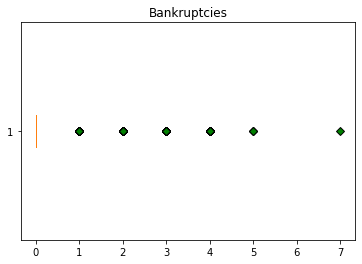

In [86]:
green_diamond = dict(markerfacecolor='g', marker='D')

fig, ax = plt.subplots()
ax.set_title('Bankruptcies')
ax.boxplot(df['Bankruptcies'], flierprops=green_diamond, vert=False)
plt.show()

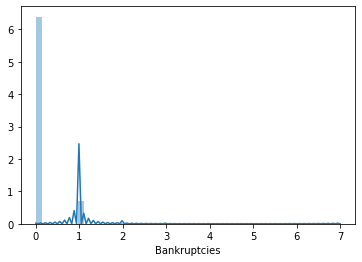

In [87]:
x = df['Bankruptcies']
sns.distplot(x);

#Tax Liens: 

certificati di debito emanati dalla contea dovuti a tasse non pagate su di una proprietà.
Si può quindi dedurre che nel dataset rappresentino il numero di certificati di non pagamento posseduti dal cliente, in senso attivo se investe in questi certificati o passivo se ha mancato nel pagamento di qualche tassa.

Non possiamo dunque considerare outliers valori di questa feature.

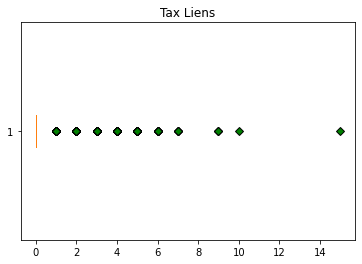

In [88]:
green_diamond = dict(markerfacecolor='g', marker='D')

fig, ax = plt.subplots()
ax.set_title('Tax Liens')
ax.boxplot(df['Tax Liens'], flierprops=green_diamond, vert=False)
plt.show()

#Current Credit Balance

anche qui vi erano due record isolati e distanti che sono stati rimossi oltre la soglia di 8 milioni

In [89]:
import plotly.express as px
x = df['Current Credit Balance'].values
fig = px.histogram(df, x='Current Credit Balance')
fig.show()
df

Loan Status  Current Loan Amount  ... Bankruptcies  Tax Liens
1       Fully Paid             262328.0  ...          0.0        0.0
2       Fully Paid           99999999.0  ...          0.0        0.0
4       Fully Paid             176220.0  ...          0.0        0.0
5      Charged Off             206602.0  ...          0.0        0.0
6       Fully Paid             217646.0  ...          1.0        0.0
...            ...                  ...  ...          ...        ...
99994   Fully Paid             210584.0  ...          0.0        0.0
99996   Fully Paid           99999999.0  ...          0.0        0.0
99997   Fully Paid             103136.0  ...          1.0        0.0
99998   Fully Paid             530332.0  ...          0.0        0.0
99999   Fully Paid           99999999.0  ...          1.0        0.0

[79568 rows x 16 columns]

In [90]:
df.loc[df['Current Credit Balance'] > 8000000]

print (df['Current Credit Balance'] > 8000000)
print(" ")
print ("--- elimino il record")
print(" ")
df = df[df['Current Credit Balance'] < 8000000]

1        False
2        False
4        False
5        False
6        False
         ...  
99994    False
99996    False
99997    False
99998    False
99999    False
Name: Current Credit Balance, Length: 79568, dtype: bool
 
--- elimino il record
 


#Monthly Debt

c'è un solo punto isolato e molto distanziato rispetto agli altri, è stato deciso di rimuoverlo per non incidere troppo sulla distribuzione rappresentando anch'esso, probabilmente, un caso particolare ed estremo del constesto di business

In [91]:
df.loc[df['Monthly Debt'] > 150000]

print (df.loc[df['Monthly Debt'] > 150000])
print(" ")
print ("--- elimino il record")
print(" ")
df = df[df['Monthly Debt'] <150000]
print (df.loc[df['Monthly Debt'] <150000])

       Loan Status  Current Loan Amount  ... Bankruptcies  Tax Liens
11648   Fully Paid              78628.0  ...          0.0        0.0
21932   Fully Paid           99999999.0  ...          0.0        0.0
25003  Charged Off             350416.0  ...          0.0        0.0
55825   Fully Paid           99999999.0  ...          0.0        0.0
77687   Fully Paid             768768.0  ...          0.0        3.0
96842   Fully Paid             786874.0  ...          0.0        0.0

[6 rows x 16 columns]
 
--- elimino il record
 
       Loan Status  Current Loan Amount  ... Bankruptcies  Tax Liens
1       Fully Paid             262328.0  ...          0.0        0.0
2       Fully Paid           99999999.0  ...          0.0        0.0
4       Fully Paid             176220.0  ...          0.0        0.0
5      Charged Off             206602.0  ...          0.0        0.0
6       Fully Paid             217646.0  ...          1.0        0.0
...            ...                  ...  ...          

In [92]:
import plotly.express as px
x = df['Monthly Debt'].values
fig = px.histogram(df, x='Monthly Debt')
fig.show()
df

Loan Status  Current Loan Amount  ... Bankruptcies  Tax Liens
1       Fully Paid             262328.0  ...          0.0        0.0
2       Fully Paid           99999999.0  ...          0.0        0.0
4       Fully Paid             176220.0  ...          0.0        0.0
5      Charged Off             206602.0  ...          0.0        0.0
6       Fully Paid             217646.0  ...          1.0        0.0
...            ...                  ...  ...          ...        ...
99994   Fully Paid             210584.0  ...          0.0        0.0
99996   Fully Paid           99999999.0  ...          0.0        0.0
99997   Fully Paid             103136.0  ...          1.0        0.0
99998   Fully Paid             530332.0  ...          0.0        0.0
99999   Fully Paid           99999999.0  ...          1.0        0.0

[79559 rows x 16 columns]

#Maximum Open Credit

la distribuzione di questa feature è troppo estesa, con valori concentrati in un piccolo range ( fino a un valore di circa 200M) per poi avere pochi record isolati a grandi distanze. si è deciso di rimuovere i record oltre la soglia di 200M per eliminare questi record isolati ed appartenenti a casi particolari o ad errori umani

In [93]:
import plotly.express as px
x = df['Maximum Open Credit'].values
fig = px.histogram(df, x='Maximum Open Credit')
fig.show()

In [94]:
df.loc[df['Maximum Open Credit'] > 80000000]

print (df.loc[df['Maximum Open Credit'] > 80000000])
print(" ")
print ("--- elimino il record")
print(" ")
df = df[df['Maximum Open Credit'] < 80000000]
print (df.loc[df['Maximum Open Credit'] > 80000000])

       Loan Status  Current Loan Amount  ... Bankruptcies  Tax Liens
594     Fully Paid             777084.0  ...          0.0        0.0
3429    Fully Paid           99999999.0  ...          0.0        0.0
4778   Charged Off             219604.0  ...          0.0        0.0
7412    Fully Paid             605902.0  ...          0.0        0.0
8993    Fully Paid             257620.0  ...          0.0        0.0
13010   Fully Paid              33110.0  ...          0.0        0.0
28811   Fully Paid             109362.0  ...          0.0        0.0
30604   Fully Paid             757218.0  ...          0.0        0.0
31037   Fully Paid             529892.0  ...          0.0        0.0
44808   Fully Paid             570086.0  ...          0.0        0.0
49860  Charged Off             741092.0  ...          0.0        0.0
64581   Fully Paid              50116.0  ...          0.0        0.0
68482   Fully Paid             108790.0  ...          0.0        0.0
88591   Fully Paid             117

#Annual Income

i record sono raggruppati in un range da 0 a venti milioni. tutti i record all'infuori di questo range sono sparsi ed a grandi distanze in termini economici. si è dunque deciso di eliminare tali valori considerandoli come outliers dovuti a casi estremi e rari

In [95]:
import plotly.express as px
x = df['Annual Income'].values
fig = px.histogram(df, x='Annual Income')
fig.show()

In [96]:
print (df.loc[df['Annual Income'] > 20000000])
print(" ")
print ("--- elimino il record")
print(" ")
df = df[df['Annual Income'] < 20000000]
print (df.loc[df['Annual Income'] > 20000000])

       Loan Status  Current Loan Amount  ... Bankruptcies  Tax Liens
10721  Charged Off             757460.0  ...          0.0        0.0
21598  Charged Off             753214.0  ...          0.0        0.0
29203   Fully Paid             541530.0  ...          0.0        0.0
30665   Fully Paid           99999999.0  ...          0.0        0.0
37858   Fully Paid             622402.0  ...          0.0        0.0
58682   Fully Paid             759066.0  ...          0.0        4.0
85662  Charged Off             176132.0  ...          0.0        0.0

[7 rows x 16 columns]
 
--- elimino il record
 
Empty DataFrame
Columns: [Loan Status, Current Loan Amount, Term, Credit Score, Annual Income, Years in current job, Home Ownership, Purpose, Monthly Debt, Years of Credit History, Number of Open Accounts, Number of Credit Problems, Current Credit Balance, Maximum Open Credit, Bankruptcies, Tax Liens]
Index: []


#current loan amount

vi sono due gruppi distinti di dati, uno con un valore della feature compreso tra 0 e 1m, l'altro col valore costante di 100m.
non è ben chiaro se questo secondo gruppo di valori appartenga ad una categoria particolare di record, anche se è stato notato come tutti i record appartenenti a questo secondo gruppo abbiamo la feature "loan status" settata a "full paid". 
potrebbe dunque trattarsi di un valore di default inserito qunado il debito viene pienamente pagato, ma tale assunzione non è confermata dallo scatter plot presentato. si è deciso dunque di non operare su tali record, in quanto non essendo certi della semantica di tale valore, non si vuole rischiare di modificare la distribuzione e le statistiche intrinseche nei valori.

In [97]:
x = df['Current Loan Amount']
x = df['Maximum Open Credit']
color= df['Loan Status'].values

import plotly.express as px
fig = px.scatter(df, x='Current Loan Amount', y='Maximum Open Credit', color='Loan Status')
fig.show()

In [98]:
import plotly.express as px
x = df['Current Loan Amount'].values
fig = px.histogram(df, x='Current Loan Amount')
fig.show()

In [99]:
df

Loan Status  Current Loan Amount  ... Bankruptcies  Tax Liens
1       Fully Paid             262328.0  ...          0.0        0.0
2       Fully Paid           99999999.0  ...          0.0        0.0
4       Fully Paid             176220.0  ...          0.0        0.0
5      Charged Off             206602.0  ...          0.0        0.0
6       Fully Paid             217646.0  ...          1.0        0.0
...            ...                  ...  ...          ...        ...
99994   Fully Paid             210584.0  ...          0.0        0.0
99996   Fully Paid           99999999.0  ...          0.0        0.0
99997   Fully Paid             103136.0  ...          1.0        0.0
99998   Fully Paid             530332.0  ...          0.0        0.0
99999   Fully Paid           99999999.0  ...          1.0        0.0

[79535 rows x 16 columns]

In [100]:
df.describe()

Current Loan Amount  Credit Score  ...  Bankruptcies     Tax Liens
count         7.953500e+04  79535.000000  ...  79535.000000  79535.000000
mean          1.469649e+07    712.333891  ...      0.112554      0.027636
std           3.503608e+07     29.179986  ...      0.343171      0.250612
min           1.080200e+04    585.000000  ...      0.000000      0.000000
25%           1.826990e+05    683.000000  ...      0.000000      0.000000
50%           3.160740e+05    720.000000  ...      0.000000      0.000000
75%           5.397040e+05    739.000000  ...      0.000000      0.000000
max           1.000000e+08    751.000000  ...      7.000000     15.000000

[8 rows x 11 columns]

# DATA TRANSFORMATION

In [102]:
df

Loan Status  Current Loan Amount  ... Bankruptcies  Tax Liens
1       Fully Paid             262328.0  ...          0.0        0.0
2       Fully Paid           99999999.0  ...          0.0        0.0
4       Fully Paid             176220.0  ...          0.0        0.0
5      Charged Off             206602.0  ...          0.0        0.0
6       Fully Paid             217646.0  ...          1.0        0.0
...            ...                  ...  ...          ...        ...
99994   Fully Paid             210584.0  ...          0.0        0.0
99996   Fully Paid           99999999.0  ...          0.0        0.0
99997   Fully Paid             103136.0  ...          1.0        0.0
99998   Fully Paid             530332.0  ...          0.0        0.0
99999   Fully Paid           99999999.0  ...          1.0        0.0

[79535 rows x 16 columns]

#SALVO DATI FINALI

In [0]:
df.to_csv('/content/drive/My Drive/PROGETTO DATA MINING 1/ASSOCIATIONS_RULES/with_rules.csv') 